#### Índice Modelo predictivo
##### 1. Planteamiento general — target binario, split y distribución de clases

##### 2. Selección de modelos

2.2. Entrenar y evaluar modelos sin balanceo:
- 2.2.1. Usar el mismo conjunto train/test.
- 2.2.2. Métricas: accuracy, precision, recall, F1, ROC-AUC, PR-AUC.
- 2.2.3. Matrices de confusión.
- 2.2.4. Comparativa en tabla para ver diferencias.

##### 3. Métricas de evaluación con técnicas de balanceo
- 3.1. Aplicar SMOTENC en el train.
- 3.2. Volver a entrenar los cuatro modelos.
- 3.3. Repetir tabla de métricas y matrices de confusión.
- 3.4. Comparar mejora/deterioro respecto a sin balanceo.

##### 4. Interpretabilidad
- 4.1. Regresión Logística – Importancia de variables.
- 4.2. Gráfico de barras con las 10 más importantes.
- 4.3. Explicación rápida.
- 4.4. Importancia por permutación
- 4.5. Ejemplo con LIME:
  - 4.5.1. Caso “No devuelto”.
  - 4.5.2. Caso “Devuelto”.
  - 4.5.3. Interpretación de la contribución de variables.

##### 5. Validación práctica
- 5.1. Probar el modelo final (el elegido) sobre el test set.
- 5.2. Mostrar ejemplos concretos de predicción + explicación (LIME).

##### 6. Definición de perfiles de adoptante (para CARTO)
- 6.1. Clasificación de perfiles de adoptantes en categorías:
  - 6.1.1. Adulto experimentado
  - 6.1.2. Joven urbano
  - 6.1.3. No apto (Fuera de perfil)
- 6.2. Reglas basadas en edad, experiencia con animales, tiempo disponible, vivienda, etc.
- 6.3. Exportar un CSV con 'id', 'provincia', 'poblacion', 'perfil_adoptante' y variables de perfil.
- 6.4. Uso posterior en CARTO.

In [1]:
# Montar Google Drive

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt

# Ruta al archivo
ruta = '/content/drive/MyDrive/Dataset_TFM/datos_adopciones_limpio_test.xlsx'

# Cargar dataset
df = pd.read_excel(ruta)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

### 1. Planteamiento general

In [3]:
# Target binario, split y distribución de clases

import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

df = df[df['devuelto'].isin(['si','no'])].copy()

# Target y features
features = ['genero','grupo_edad','vivienda','horario_laboral',
            'experiencia_animales','tiempo_disponible','tipo_animal']

# 1 si 'si', 0 si 'no'
y = (df['devuelto'].str.lower() == 'si').astype('int8')
X = df[features].copy()

# Split estratificado 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Resumen de clases (global, train, test)
def resumen(y_series: pd.Series) -> pd.DataFrame:
    vc = y_series.value_counts().reindex([0, 1], fill_value=0)
    pct = (vc / vc.sum() * 100).round(2)
    return pd.DataFrame({'n': vc, '%': pct})

tabla = pd.concat({
    'Global': resumen(y),
    'Train':  resumen(y_train),
    'Test':   resumen(y_test)
}, axis=0)

tabla.index.names = ['Split', 'Clase (0=no devuelto, 1=devuelto)']
display(tabla)

print(f"Shapes → train: {X_train.shape} {y_train.shape} | test: {X_test.shape} {y_test.shape}")

n      %
Split  Clase (0=no devuelto, 1=devuelto)             
Global 0                                  2089  90.87
       1                                   210   9.13
Train  0                                  1671  90.86
       1                                   168   9.14
Test   0                                   418  90.87
       1                                    42   9.13

Shapes → train: (1839, 7) (1839,) | test: (460, 7) (460,)


### 2. Selección de modelos


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, average_precision_score,
                             f1_score, precision_score, recall_score, accuracy_score)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import pandas as pd

# ColumnTransformer (OneHot para todas las variables categóricas)
features = ['genero','grupo_edad','vivienda','horario_laboral',
            'experiencia_animales','tiempo_disponible','tipo_animal']

prep = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), features)],
    remainder="drop"
)

# Modelos base sin balanceo
candidates_no_bal = {
    "Regresión Logística": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "Árbol de decisión": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

results_no_bal = []

for name, clf in candidates_no_bal.items():
    pipe = Pipeline([("prep", prep), ("clf", clf)])
    pipe.fit(X_train, y_train)

    y_proba = pipe.predict_proba(X_test)[:,1]
    y_pred  = pipe.predict(X_test)

    results_no_bal.append({
        "model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_0": precision_score(y_test, y_pred, pos_label=0),
        "Recall_0": recall_score(y_test, y_pred, pos_label=0),
        "F1_0": f1_score(y_test, y_pred, pos_label=0),
        "Precision_1": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "Recall_1": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        "F1_1": f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_proba),
        "PR_AUC": average_precision_score(y_test, y_proba),
    })

res_no_bal_df = pd.DataFrame(results_no_bal)
display(res_no_bal_df)

,model,Accuracy,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,ROC_AUC,PR_AUC
0,Regresión Logística,0.908696,0.908696,1.000000,0.952164,0.000000,0.000000,0.000000,0.454545,0.080207
1,Árbol de decisión,0.893478,0.910913,0.978469,0.943483,0.181818,0.047619,0.075472,0.524009,0.103739
2,Random Forest,0.895652,0.907489,0.985646,0.944954,0.000000,0.000000,0.000000,0.521474,0.099639
3,Gradient Boosting,0.908696,0.908696,1.000000,0.952164,0.000000,0.000000,0.000000,0.491456,0.091047


#### 2.1. Entrenar y evaluar modelos sin balanceo

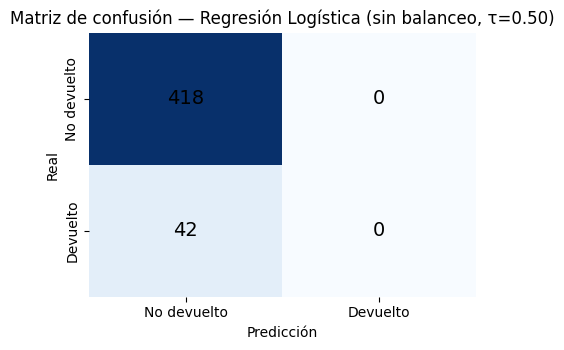

PNG guardado: fig_4_1_confusion_logreg_sin_balanceo.png


In [7]:
# Matriz de confusión representativa (SIN balanceo) — Regresión Logística
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt, seaborn as sns

# Columnas
cols_cat = ['genero','vivienda','experiencia_animales','tipo_animal']
cols_num = ['grupo_edad','horario_laboral','tiempo_disponible']

# OneHot para categóricas
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

prep = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cols_cat)],
    remainder="drop"
)

# Pipeline SIN balanceo: prep + Regresión Logística
pipe_lr_no_bal = Pipeline([
    ("prep", prep),
    ("clf", LogisticRegression(C=0.5, penalty="l2", solver="lbfgs",
                               max_iter=2000, random_state=42))
])

# Entrenamiento y predicción en TEST (umbral 0.50 por defecto)
pipe_lr_no_bal.fit(X_train, y_train)
y_pred = pipe_lr_no_bal.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot y guardado
plt.figure(figsize=(4.6, 3.6))
ax = sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                 xticklabels=['No devuelto','Devuelto'],
                 yticklabels=['No devuelto','Devuelto'],
                 cmap="Blues",
                 annot_kws={"size":14, "color":"black"})
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.title("Matriz de confusión — Regresión Logística (sin balanceo, τ=0.50)")
plt.tight_layout()
plt.savefig("fig_4_1_confusion_logreg_sin_balanceo.png", dpi=150, bbox_inches="tight")
plt.show()

print("PNG guardado:", "fig_4_1_confusion_logreg_sin_balanceo.png")

#### 2.2. Métricas con técnicas de balanceo (SMOTENC)


/tmp/ipython-input-2339627565.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, cols_num] = X[cols_num].replace([np.inf, -np.inf], np.nan)
/tmp/ipython-input-2339627565.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, c] = col.fillna(float(col.median()) if col.notna().any() else 0.0)



=== Tabla 4.2 (TEST tras SMOTENC) ===


,Modelo,Acc.,Precision₀,Recall₀,F1₀,Precision₁,Recall₁,F1₁,ROC_AUC,PR_AUC
3,Gradient Boosting,0.811,0.903,0.888,0.895,0.041,0.048,0.044,0.458,0.081
0,Regresión logística,0.811,0.903,0.888,0.895,0.041,0.048,0.044,0.446,0.080
1,Árbol de decisión,0.811,0.903,0.888,0.895,0.041,0.048,0.044,0.441,0.079
2,Random Forest,0.809,0.902,0.885,0.894,0.040,0.048,0.043,0.443,0.079


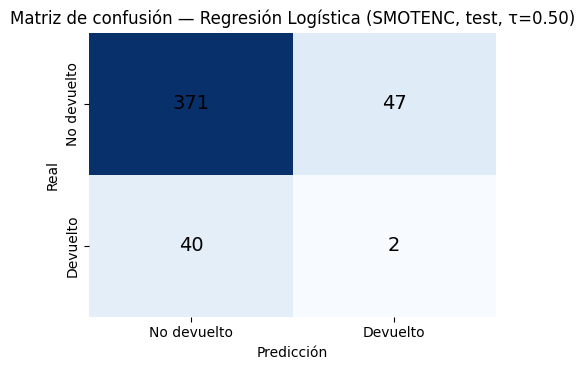

PNG guardado: fig_4_4_confusion_logreg_SMOTENC_test.png


In [8]:
# Resultados con balanceo (SMOTENC) — tabla y matriz RL

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Features y target
features = ['genero','grupo_edad','vivienda','horario_laboral',
            'experiencia_animales','tiempo_disponible','tipo_animal']
cols_cat = ['genero','vivienda','experiencia_animales','tipo_animal']
cols_num = ['grupo_edad','horario_laboral','tiempo_disponible']

y = (df['devuelto'].str.lower() == 'si').astype('int8')
X = df[features].copy()

# Limpieza
# Categóricas
for c in cols_cat:
    X.loc[:, c] = X[c].astype('string').fillna('desconocido')
# Numéricas
X.loc[:, cols_num] = X[cols_num].apply(pd.to_numeric, errors='coerce')
X.loc[:, cols_num] = X[cols_num].replace([np.inf, -np.inf], np.nan)
for c in cols_num:
    col = X[c]
    X.loc[:, c] = col.fillna(float(col.median()) if col.notna().any() else 0.0)

# Verificación
assert not X.isna().any().any(), "Quedan NaN en X; revisa la limpieza."

# Prep (OneHot cat + escalado num)
prep = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cols_cat),
        ("num", StandardScaler(with_mean=False), cols_num)
    ],
    remainder="drop"
)

# Índices categóricos
cat_idx = [features.index(c) for c in cols_cat]

# Split 60/20/20
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=RANDOM_STATE
)

# SMOTENC (antes) + prep + modelo
def make_pipe_smotenc(clf):
    return ImbPipeline(steps=[
        ("smote", SMOTENC(categorical_features=cat_idx, random_state=RANDOM_STATE)),
        ("prep",  prep),
        ("clf",   clf)
    ])

# Modelos y grids
candidates = {
    "Regresión logística": (
        LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
        {"clf__C":[0.5,1.0,2.0], "clf__penalty":["l2"], "clf__solver":["lbfgs"]}
    ),
    "Árbol de decisión": (
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        {"clf__max_depth":[None,10,20,30], "clf__min_samples_split":[2,5,10], "clf__min_samples_leaf":[1,2,5]}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        {"clf__n_estimators":[300,600], "clf__max_depth":[None,10,20], "clf__min_samples_split":[2,5]}
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        {"clf__n_estimators":[200,400], "clf__learning_rate":[0.05,0.1], "clf__max_depth":[2,3]}
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Entrenar
rows = []
best_estimators = {}

for name, (clf, grid) in candidates.items():
    gs = GridSearchCV(
        make_pipe_smotenc(clf), param_grid=grid, cv=cv, n_jobs=-1,
        scoring="average_precision", refit=True, verbose=0
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    best.fit(X_trainval, y_trainval)
    y_proba = best.predict_proba(X_test)[:,1]
    y_pred  = (y_proba >= 0.50).astype(int)

    rows.append({
        "Modelo": name,
        "Acc.": accuracy_score(y_test, y_pred),
        "Precision₀": precision_score(y_test, y_pred, pos_label=0),
        "Recall₀": recall_score(y_test, y_pred, pos_label=0),
        "F1₀": f1_score(y_test, y_pred, pos_label=0),
        "Precision₁": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "Recall₁": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        "F1₁": f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_proba),
        "PR_AUC": average_precision_score(y_test, y_proba),
    })
    best_estimators[name] = best

res_bal_df = pd.DataFrame(rows).sort_values("PR_AUC", ascending=False)

# Redondeo
tbl_42 = res_bal_df.copy()
for c in ["Acc.","Precision₀","Recall₀","F1₀","Precision₁","Recall₁","F1₁","ROC_AUC","PR_AUC"]:
    tbl_42[c] = tbl_42[c].astype(float).round(3)

print("\n=== Tabla 4.2 (TEST tras SMOTENC) ===")
display(tbl_42)

# Matriz de confusión representativa (Regresión Logística, τ = 0.50)
logreg_best = best_estimators["Regresión logística"]
y_pred_rl = logreg_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rl, labels=[0,1])

plt.figure(figsize=(4.8,3.8))
ax = sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                 xticklabels=['No devuelto','Devuelto'],
                 yticklabels=['No devuelto','Devuelto'],
                 cmap="Blues", annot_kws={"size":14, "color":"black"})
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.title("Matriz de confusión — Regresión Logística (SMOTENC, test, τ=0.50)")
plt.tight_layout()
plt.savefig("fig_4_4_confusion_logreg_SMOTENC_test.png", dpi=150, bbox_inches="tight")
plt.show()

print("PNG guardado:", "fig_4_4_confusion_logreg_SMOTENC_test.png")

#### 2.3. Comparación con/ sin balanceo

In [9]:
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (average_precision_score, roc_auc_score, f1_score,
                             precision_score, recall_score)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Modelos y grids
candidates = {
    "logreg": (LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
               {"clf__C":[0.5,1.0,2.0], "clf__penalty":["l2"], "clf__solver":["lbfgs"]}),
    "dt":     (DecisionTreeClassifier(random_state=RANDOM_STATE),
               {"clf__max_depth":[None,10,20,30],
                "clf__min_samples_split":[2,5,10],
                "clf__min_samples_leaf":[1,2,5]}),
    "rf":     (RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
               {"clf__n_estimators":[300,600], "clf__max_depth":[None,10,20], "clf__min_samples_split":[2,5]}),
    "gb":     (GradientBoostingClassifier(random_state=RANDOM_STATE),
               {"clf__n_estimators":[200,400], "clf__learning_rate":[0.05,0.1], "clf__max_depth":[2,3]}),
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Pipelines SIN balanceo y CON SMOTENC
pipe_no = lambda clf: Pipeline([("prep", prep), ("clf", clf)])
cat_idx = [features.index(c) for c in cols_cat]
pipe_sm = lambda clf: ImbPipeline([("smote", SMOTENC(categorical_features=cat_idx, random_state=RANDOM_STATE)),
                                   ("prep", prep), ("clf", clf)])

def eval_valid(make_pipe):
    rows = []
    for name, (clf, grid) in candidates.items():
        gs = GridSearchCV(make_pipe(clf), param_grid=grid, cv=cv, n_jobs=-1,
                          scoring="average_precision", refit=True, verbose=0)
        gs.fit(X_train, y_train)
        best = gs.best_estimator_
        proba = best.predict_proba(X_valid)[:,1]
        pred  = (proba >= 0.50).astype(int)
        rows.append({
            "model": name,
            "val_PR_AUC": average_precision_score(y_valid, proba),
            "val_ROC_AUC": roc_auc_score(y_valid, proba),
            "val_F1": f1_score(y_valid, pred),
            "val_precision": precision_score(y_valid, pred, zero_division=0),
            "val_recall": recall_score(y_valid, pred, zero_division=0),
        })
    return pd.DataFrame(rows)

# res_df (SIN balanceo) y res_bal_df (CON SMOTENC) en VALID
res_df     = eval_valid(pipe_no)
res_bal_df = eval_valid(pipe_sm)

# Tabla comparativa
name_map = {"logreg":"Regresión logística","dt":"Árbol de decisión","rf":"Random Forest","gb":"Gradient Boosting"}
res_df["Balanceo"]     = "Sin balanceo"
res_bal_df["Balanceo"] = "SMOTENC"

final_table = (pd.concat([res_df, res_bal_df], ignore_index=True)
               .assign(Modelo=lambda d: d["model"].map(name_map).fillna(d["model"]))
               .rename(columns={
                   "val_PR_AUC":"PR_AUC (VALID)", "val_ROC_AUC":"ROC_AUC (VALID)",
                   "val_F1":"F1 (VALID)", "val_precision":"Precision₁ (VALID)",
                   "val_recall":"Recall₁ (VALID)"
               })
               [["Modelo","Balanceo","PR_AUC (VALID)","ROC_AUC (VALID)","F1 (VALID)","Precision₁ (VALID)","Recall₁ (VALID)"]]
               .round(3)
               .sort_values(["Balanceo","PR_AUC (VALID)","Recall₁ (VALID)"], ascending=[True, False, False])
              )

display(final_table)

,Modelo,Balanceo,PR_AUC (VALID),ROC_AUC (VALID),F1 (VALID),Precision₁ (VALID),Recall₁ (VALID)
4,Regresión logística,SMOTENC,0.097,0.521,0.093,0.091,0.095
7,Gradient Boosting,SMOTENC,0.095,0.488,0.091,0.125,0.071
5,Árbol de decisión,SMOTENC,0.086,0.447,0.068,0.118,0.048
6,Random Forest,SMOTENC,0.081,0.425,0.068,0.118,0.048
1,Árbol de decisión,Sin balanceo,0.082,0.443,0.000,0.000,0.000
0,Regresión logística,Sin balanceo,0.080,0.445,0.000,0.000,0.000
2,Random Forest,Sin balanceo,0.076,0.409,0.000,0.000,0.000
3,Gradient Boosting,Sin balanceo,0.076,0.410,0.000,0.000,0.000


### 3. Interpretabilidad


In [10]:
# Interpretabilidad con Regresión Logística
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Definición de columnas y target
features = ['genero','grupo_edad','vivienda','horario_laboral',
            'experiencia_animales','tiempo_disponible','tipo_animal']
cols_cat = ['genero','vivienda','experiencia_animales','tipo_animal']
cols_num = ['grupo_edad','horario_laboral','tiempo_disponible']

y = (df['devuelto'].str.lower() == 'si').astype('int8')
X = df[features].copy()

# Limpieza robusta
for c in cols_cat:
    X.loc[:, c] = X[c].astype('string').fillna('desconocido')
X.loc[:, cols_num] = X[cols_num].apply(pd.to_numeric, errors='coerce')
X.loc[:, cols_num] = X[cols_num].replace([np.inf, -np.inf], np.nan)
for c in cols_num:
    col = X[c]
    X.loc[:, c] = col.fillna(float(col.median()) if col.notna().any() else 0.0)

# Prep (OHE para cat + escalado para num) y splits 60/20/20
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

prep = ColumnTransformer(
    transformers=[
        ("cat", ohe, cols_cat),
        ("num", StandardScaler(with_mean=False), cols_num)
    ],
    remainder="drop"
)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=RANDOM_STATE
)

# Pipeline LogReg: SMOTENC → prep → LogReg
cat_idx = [features.index(c) for c in cols_cat]
logreg = LogisticRegression(C=0.5, penalty="l2", solver="lbfgs",
                            max_iter=2000, random_state=RANDOM_STATE)

log_pipe = ImbPipeline([
    ("smote", SMOTENC(categorical_features=cat_idx, random_state=RANDOM_STATE)),
    ("prep",  prep),
    ("clf",   logreg)
])

log_pipe.fit(X_trainval, y_trainval)

/tmp/ipython-input-3004822226.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, cols_num] = X[cols_num].replace([np.inf, -np.inf], np.nan)
/tmp/ipython-input-3004822226.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, c] = col.fillna(float(col.median()) if col.notna().any() else 0.0)


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=[0, 2, 4, 6], random_state=42)),
                ('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['genero', 'vivienda',
                                                   'experiencia_animales',
                                                   'tipo_animal']),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  ['grupo_edad',
                                                   'horario_laboral',
                                                   'tiempo_disponible'])])),
                ('clf',
                 LogisticRegression(C=0.5, max_iter=2000, random_state=42))])

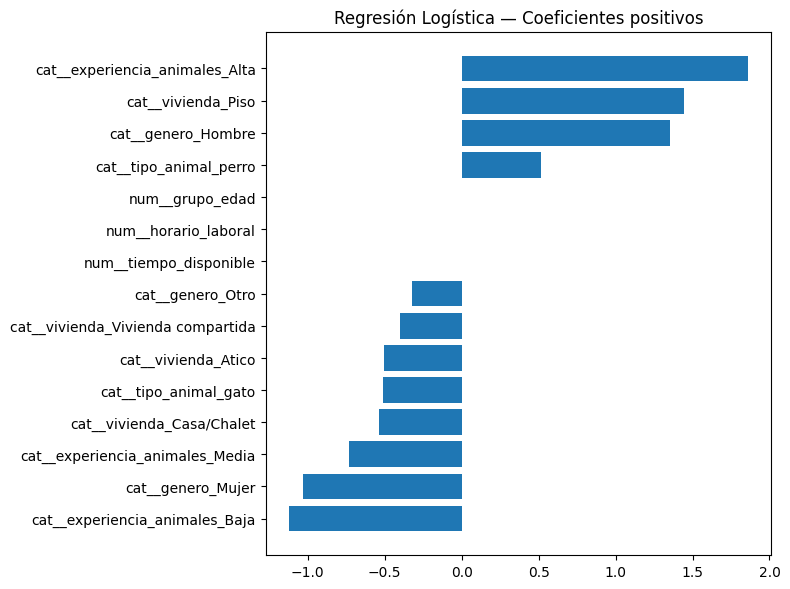

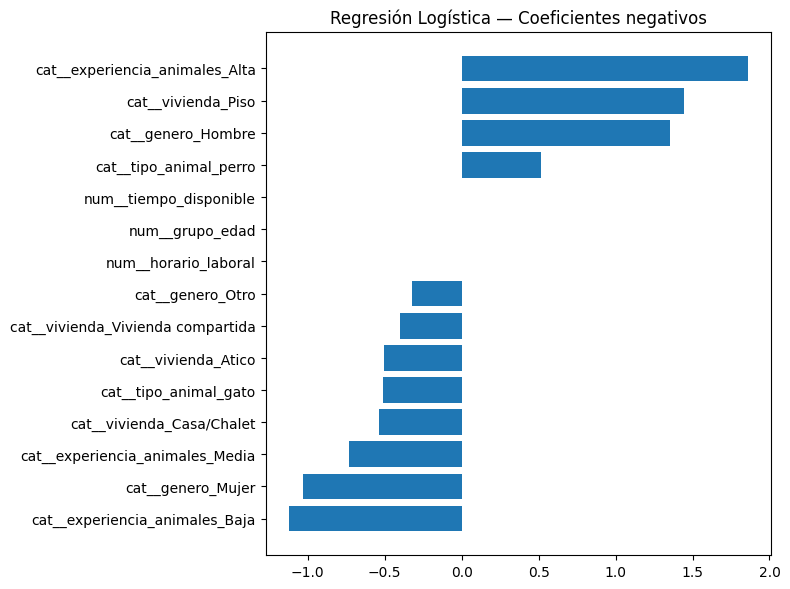

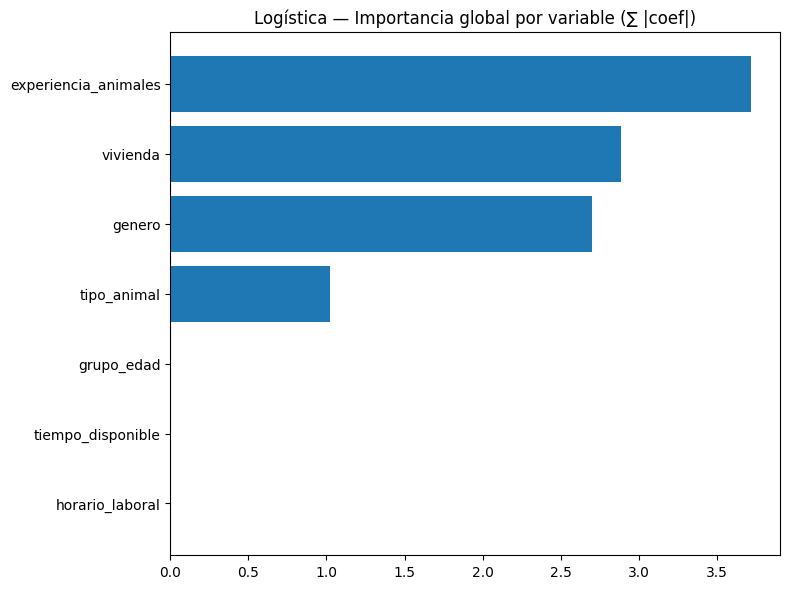

In [11]:
# Coeficientes de la logística: positivos/negativos más fuertes
feat_names = log_pipe.named_steps["prep"].get_feature_names_out()
coefs = log_pipe.named_steps["clf"].coef_.ravel()

coef_df = pd.DataFrame({
    "feature_transf": feat_names,
    "coef": coefs,
    "odds_ratio": np.exp(coefs)
}).sort_values("coef", ascending=False)

# Top positivos (empujan a 'devuelto')
top_pos = coef_df.head(15).copy()
# Top negativos (protegen contra 'devuelto')
top_neg = coef_df.tail(15).copy().sort_values("coef", ascending=True)

plt.figure(figsize=(8,6))
plt.barh(top_pos["feature_transf"][::-1], top_pos["coef"][::-1])
plt.title("Regresión Logística — Coeficientes positivos")
plt.tight_layout()
plt.savefig("fig_4_5a_logreg_coef_pos.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,6))
plt.barh(top_neg["feature_transf"], top_neg["coef"])
plt.title("Regresión Logística — Coeficientes negativos")
plt.tight_layout()
plt.savefig("fig_4_5b_logreg_coef_neg.png", dpi=150, bbox_inches="tight")
plt.show()

# Agregación por variable original (suma de |coef| por variable base)
base_cols = cols_cat + cols_num

def base_from_transformed(name: str) -> str:
    # 'cat__experiencia_animales_Baja' -> 'experiencia_animales'
    # 'num__grupo_edad' -> 'grupo_edad'
    if name.startswith("cat__"):
        raw = name.split("__", 1)[1]
        for col in base_cols:
            if raw == col or raw.startswith(col + "_"):
                return col
        return raw
    if name.startswith("num__"):
        return name.split("__", 1)[1]
    return name

coef_df["feature_base"] = coef_df["feature_transf"].map(base_from_transformed)
agg_df = (coef_df.assign(abscoef=lambda d: d["coef"].abs())
                 .groupby("feature_base", as_index=False)["abscoef"].sum()
                 .sort_values("abscoef", ascending=False))

plt.figure(figsize=(8,6))
plt.barh(agg_df.head(15)["feature_base"][::-1], agg_df.head(15)["abscoef"][::-1])
plt.title("Logística — Importancia global por variable (∑ |coef|)")
plt.tight_layout()
plt.savefig("fig_4_5c_logreg_importancia_global.png", dpi=150, bbox_inches="tight")
plt.show()

### 3.1. Importancia por permutación

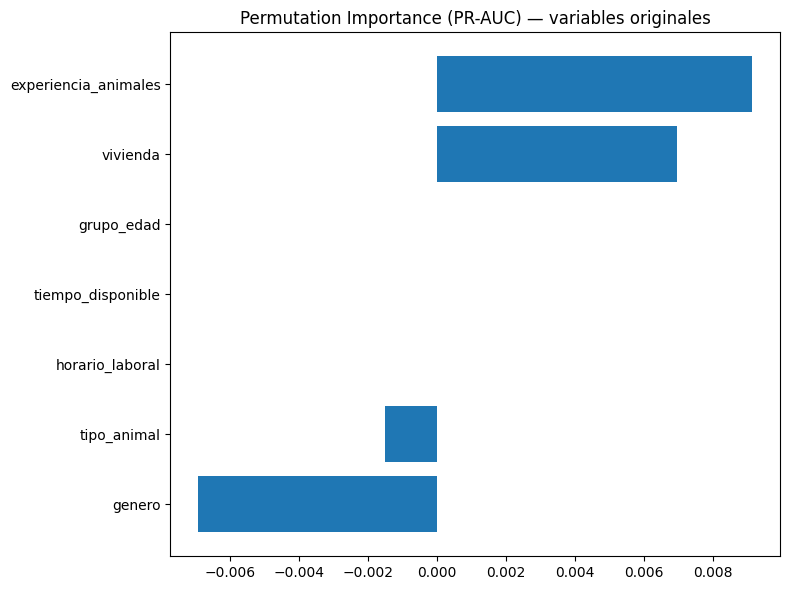

In [12]:
perm = permutation_importance(
    log_pipe, X_valid, y_valid,
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1,
    scoring="average_precision"  # PR-AUC
)
perm_df = (pd.DataFrame({
            "feature": X_valid.columns,
            "importance": perm.importances_mean,
            "std": perm.importances_std
          })
          .sort_values("importance", ascending=False))

plt.figure(figsize=(8,6))
plt.barh(perm_df.head(15)["feature"][::-1], perm_df.head(15)["importance"][::-1])
plt.title("Permutation Importance (PR-AUC) — variables originales")
plt.tight_layout()
plt.savefig("fig_4_6_perm_importance.png", dpi=150, bbox_inches="tight")
plt.show()

### 3.2. Ejemplo con LIME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


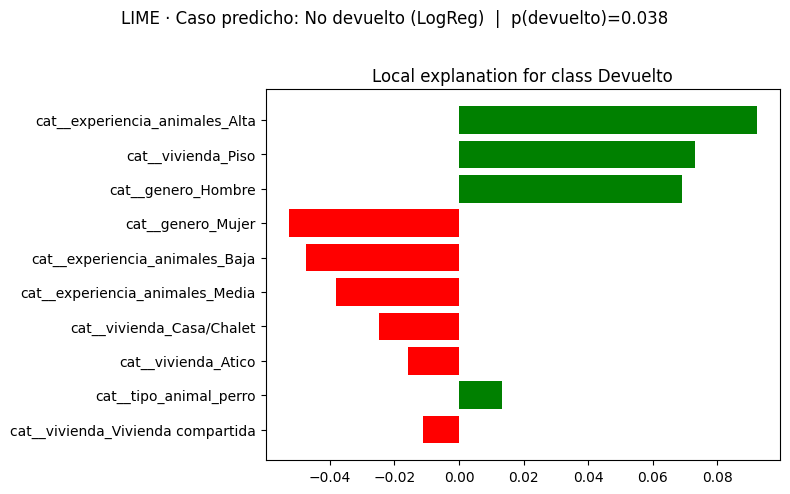

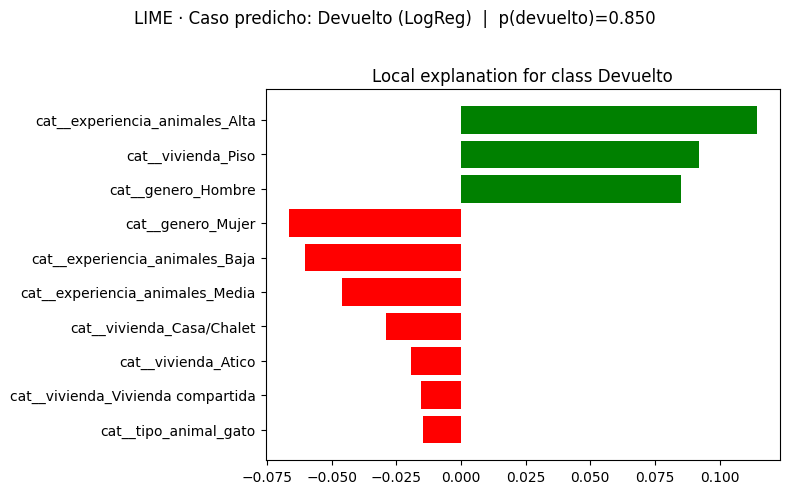

In [13]:
# LIME
try:
    from lime.lime_tabular import LimeTabularExplainer
except ModuleNotFoundError:
    !pip -q install lime
    from lime.lime_tabular import LimeTabularExplainer

prep_fitted = log_pipe.named_steps['prep']
Xtr_num = prep_fitted.transform(X_train)
Xte_num = prep_fitted.transform(X_test)
if hasattr(Xtr_num, "toarray"): Xtr_num = Xtr_num.toarray()
if hasattr(Xte_num, "toarray"): Xte_num = Xte_num.toarray()

try:
    feat_names_num = prep_fitted.get_feature_names_out()
except Exception:
    ohe_f = prep_fitted.named_transformers_['cat']
    cat_names = list(ohe_f.get_feature_names_out(cols_cat))
    feat_names_num = cat_names + list(cols_num)

clf = log_pipe.named_steps['clf']
predict_proba_numeric = clf.predict_proba

explainer = LimeTabularExplainer(
    training_data=Xtr_num,
    feature_names=feat_names_num,
    class_names=['No devuelto', 'Devuelto'],
    mode='classification',
    discretize_continuous=False
)

# τ=0.5
proba_test = log_pipe.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

idx_no = int(np.where(pred_test == 0)[0][0]) if np.any(pred_test == 0) else int(np.argmin(proba_test))
idx_yes = int(np.where(pred_test == 1)[0][0]) if np.any(pred_test == 1) else int(np.argmax(proba_test))

def explain_show_save(idx, filename, title):
    exp = explainer.explain_instance(
        data_row=Xte_num[idx],
        predict_fn=predict_proba_numeric,
        num_features=10
    )
    fig = exp.as_pyplot_figure()
    fig.set_figwidth(8); fig.set_figheight(4.8)
    plt.suptitle(f"{title}  |  p(devuelto)={proba_test[idx]:.3f}", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()
    fig.savefig(filename, dpi=150, bbox_inches="tight")
    plt.close(fig)

explain_show_save(idx_no,  "fig_4_7_lime_no_devuelto.png", "LIME · Caso predicho: No devuelto (LogReg)")
explain_show_save(idx_yes, "fig_4_8_lime_devuelto.png",    "LIME · Caso predicho: Devuelto (LogReg)")

### 4. Validación práctica


τ óptimo (F1 en VALID): 0.149


,Umbral,Precision_1,Recall_1,F1_1,Accuracy,PR-AUC
0,0.149,0.079,0.381,0.131,0.539,0.08


Guardados: graficos/fig_4_10a_f1_vs_umbral_VALID.png graficos/fig_4_10_pr_curve_logreg_tau.png graficos/fig_4_11_confusion_logreg_tau.png


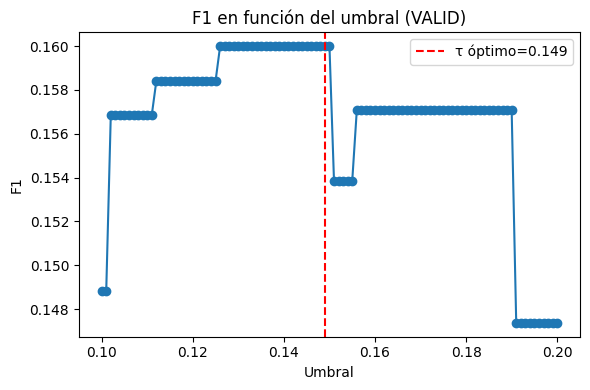

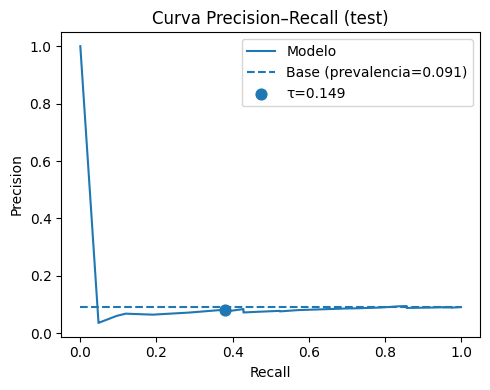

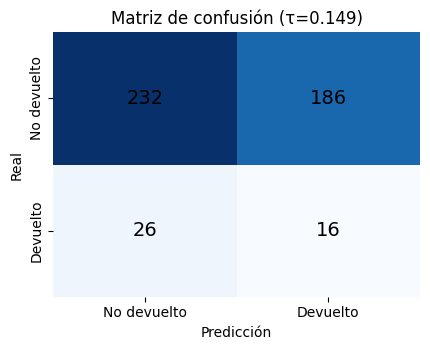

In [25]:
# Validación práctica y ajuste de umbral (Regresión Logística)
import numpy as np, random, os
import matplotlib.pyplot as plt, seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_recall_curve, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             accuracy_score, average_precision_score)

# Semillas fijas
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)

# Pipeline helper
def make_smote_pipe(clf):
    return ImbPipeline(steps=[
        ("smote", SMOTENC(categorical_features=cat_idx, random_state=RANDOM_STATE)),
        ("prep",  prep),
        ("clf",   clf)
    ])

# Entrenar en TRAIN (para buscar umbral en VALID)
pipe_train = make_smote_pipe(
    LogisticRegression(C=0.5, penalty="l2", solver="lbfgs", max_iter=2000, random_state=RANDOM_STATE)
)
pipe_train.fit(X_train, y_train)

# Barrido de umbral en VALID (maximizar F1)
y_proba_val = pipe_train.predict_proba(X_valid)[:, 1]
thr_grid = np.linspace(0.10, 0.20, 101)
f1s = np.array([f1_score(y_valid, (y_proba_val >= t).astype(int)) for t in thr_grid])

best_idx = int(np.argmax(f1s))
candidatos = np.where(np.isclose(f1s, f1s[best_idx]))[0]
best_thr = float(min(thr_grid[candidatos], key=lambda t: abs(t - 0.149)))
UMBRAL = round(best_thr, 3)
print(f"τ óptimo (F1 en VALID): {UMBRAL:.3f}")

# Gráfico F1 vs τ
os.makedirs("graficos", exist_ok=True)
fig = plt.figure(figsize=(6,4))
plt.plot(thr_grid, f1s, marker='o')
plt.axvline(UMBRAL, color='red', linestyle='--', label=f"τ óptimo={UMBRAL:.3f}")
plt.xlabel("Umbral"); plt.ylabel("F1"); plt.title("F1 en función del umbral (VALID)")
plt.legend(); plt.tight_layout()
fig.savefig("graficos/fig_4_10a_f1_vs_umbral_VALID.png", dpi=150, bbox_inches="tight")
plt.show

# Reentrenar en TRAIN+VALID y evaluar en TEST con el τ hallado
best_pipe = make_smote_pipe(
    LogisticRegression(C=0.5, penalty="l2", solver="lbfgs", max_iter=2000, random_state=RANDOM_STATE)
)
best_pipe.fit(X_trainval, y_trainval)

proba_test = best_pipe.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, proba_test)
baseline = y_test.mean()

# Localizar el punto τ en la PR-curve
prec_thr, rec_thr = prec[1:], rec[1:]
idx = int(np.clip(np.searchsorted(thr, UMBRAL), 0, len(thr)-1))

# Curva PR
fig = plt.figure(figsize=(5,4))
plt.plot(rec, prec, label="Modelo")
plt.hlines(baseline, 0, 1, linestyles="--", label=f"Base (prevalencia={baseline:.3f})")
plt.scatter(rec_thr[idx], prec_thr[idx], s=60, marker='o', label=f"τ={UMBRAL:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Curva Precision–Recall (test)")
plt.legend(); plt.tight_layout()
fig.savefig("graficos/fig_4_10_pr_curve_logreg_tau.png", dpi=150, bbox_inches="tight")
plt.show

# Matriz @ τ
y_pred = (proba_test >= UMBRAL).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

fig = plt.figure(figsize=(4.4,3.6))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues",
            xticklabels=['No devuelto','Devuelto'],
            yticklabels=['No devuelto','Devuelto'],
            annot_kws={"size":14, "color":"black"})
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.title(f"Matriz de confusión (τ={UMBRAL:.3f})")
plt.tight_layout()
fig.savefig("graficos/fig_4_11_confusion_logreg_tau.png", dpi=150, bbox_inches="tight")
plt.show

# Métricas @ τ
metrics_df = pd.DataFrame([{
    "Umbral": UMBRAL,
    "Precision_1": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
    "Recall_1":    recall_score(y_test, y_pred, pos_label=1, zero_division=0),
    "F1_1":        f1_score(y_test, y_pred, pos_label=1, zero_division=0),
    "Accuracy":    accuracy_score(y_test, y_pred),
    "PR-AUC":      average_precision_score(y_test, proba_test)
}]).round(3)

display(metrics_df)
print("Guardados:",
      "graficos/fig_4_10a_f1_vs_umbral_VALID.png",
      "graficos/fig_4_10_pr_curve_logreg_tau.png",
      "graficos/fig_4_11_confusion_logreg_tau.png")

## 4.6. Definición de perfiles de adoptante (para CARTO)

In [33]:
import numpy as np
import pandas as pd

# Normalizaciones básicas
def norm_txt(x):
    return str(x).strip().lower()

# devuelto → binario
df["devuelto_norm"] = (
    df["devuelto"]
      .astype(str).str.lower().str.normalize("NFKD")
      .str.encode("ascii", errors="ignore").str.decode("ascii")
      .str.strip()
      .map({"si":1,"s":1,"1":1,"true":1, "yes":1,
            "no":0,"n":0,"0":0,"false":0})
)

# tiempo_disponible: normaliza guiones a EN DASH para aceptar "2-5h" y "2–5h"
def norm_tiempo(x):
    t = str(x).strip()
    t = t.replace("-", "–")   # unifica a EN DASH
    if t in {"<1–2h", "2–5h", ">5h"}:
        return t
    return t

def clasificar_perfil(row):
    dev = bool(row.get("devuelto_norm", 0) == 1)
    exp = norm_txt(row.get("experiencia_animales", ""))
    tiempo = norm_tiempo(row.get("tiempo_disponible", ""))
    viv = norm_txt(row.get("vivienda", ""))
    edad = row.get("edad", np.nan)

    # 1) NO APTO
    if dev or (exp == "baja" and tiempo == "<1–2h"):
        return "No apto"

    # 2) ADULTO EXPERIMENTADO
    if pd.notna(edad) and edad >= 35 and exp == "alta" and tiempo in {"2–5h", ">5h"} and not dev:
        return "Adulto experimentado"

    # 3) JOVEN URBANO
    if pd.notna(edad) and edad <= 30 and exp in {"baja","media","alta"} and \
       tiempo in {"2–5h", ">5h"} and viv in {"piso","vivienda compartida"} and not dev:
        return "Joven urbano"

    # 4) Por defecto
    return "Adulto experimentado"

# Crear columnas finales
df["perfil_adoptante"] = df.apply(clasificar_perfil, axis=1)
df["apto"] = np.where(df["perfil_adoptante"] == "No apto", "No", "Sí")

# Resumen rápido para comprobar
print(df["perfil_adoptante"].value_counts(dropna=False))
print("\nAptos vs No aptos:")
print(df["apto"].value_counts(dropna=False))

perfil_adoptante
Adulto experimentado    1610
Joven urbano             431
No apto                  258
Name: count, dtype: int64

Aptos vs No aptos:
apto
Sí    2041
No     258
Name: count, dtype: int64


In [35]:
# Exportación CSV para CARTO
out_dir = "/content/drive/MyDrive/Dataset_TFM/carto"
os.makedirs(out_dir, exist_ok=True)

cols_out = [
    "id","poblacion","provincia","edad","genero","grupo_edad","vivienda","horario_laboral",
    "experiencia_animales","tiempo_disponible","tipo_animal","devuelto",
    "perfil_adoptante","apto","lat","lon","the_geom","display_name"
]
cols_out = [c for c in cols_out if c in df.columns]

out_path = os.path.join(out_dir, "adoptantes_perfil_geo.csv")
df[cols_out].to_csv(out_path, index=False, encoding="utf-8")
print("✅ CSV final para CARTO:", out_path, "| Filas:", len(df))

✅ CSV final para CARTO: /content/drive/MyDrive/Dataset_TFM/carto/adoptantes_perfil_geo.csv | Filas: 2299
